# Introduction

I decided to choose this dataset for my capstone project because I believe it is great for applying what we learned so far about nerual networks and deep learning on practice. The goal here is to experiment with different techniques we covered throughout the course and try to get as best result as possible.

# Data preparation

Unzipping archive with Malaria Cell Images Dataset.
The dataset itself is downloaded from [Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria)
In order for notebook to work the archive should be placed in a same directory

In [138]:
!unzip -qo 'archive.zip' -d 'data'

Filenames in this dataset are not convenient for splitting, let's rename them

In [182]:
import os

In [180]:
def rename_files(folder):   
    lastCount = 0
    for count, filename in enumerate(os.listdir(folder)):
        dst = f"{str(count)}.png"
        src =f"{folder}/{filename}" 
        dst =f"{folder}/{dst}"
        os.rename(src, dst)
        lastCount = count
    print("File count in folder %s is %s" % (folder, lastCount))

In [147]:
rename_files("./data/cell_images/Parasitized")

File count in folder ./data/cell_images/Parasitized is 13779


In [148]:
rename_files("./data/cell_images/Uninfected")

File count in folder ./data/cell_images/Uninfected is 13779


Create folders for train, val, and test dataset

In [149]:
!mkdir 'train/parasitized' -p
!mkdir 'train/uninfected' -p

!mkdir 'validation/parasitized' -p
!mkdir 'validation/uninfected' -p

!mkdir 'test/parasitized' -p
!mkdir 'test/uninfected' -p

Number of files in both categories is 13779 each. Therefore train test split should contain for each category:
* 8267 train files (0-8266)
* 2756 validation files (8267-11023) 
* 2756 test files (11024-13779)

Splitting dataset

In [151]:
!bash -c 'mv ./data/cell_images/Parasitized/{0..8266}.png train/parasitized'
!bash -c 'mv ./data/cell_images/Uninfected/{0..8266}.png train/uninfected'
!bash -c 'mv ./data/cell_images/Parasitized/{8267..11023}.png validation/parasitized'
!bash -c 'mv ./data/cell_images/Uninfected/{8267..11023}.png validation/uninfected'
!bash -c 'mv ./data/cell_images/Parasitized/{11024..13779}.png test/parasitized'
!bash -c 'mv ./data/cell_images/Uninfected/{11024..13779}.png test/uninfected'

In [152]:
!rm -drf data

Checking that we can read all files and remove invalid

In [ ]:
import os
from PIL import Image

path = ['./train', './validation', './test']

folder_path = 'train'
extensions = []
for folder_path in path:
    print("Path: %s" % folder_path)
    for fldr in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, fldr)
        for filee in os.listdir(sub_folder_path):
            file_path = os.path.join(sub_folder_path, filee)
            print('** Path: {}  **'.format(file_path), end="\r", flush=True)
            try:
                im = Image.open(file_path)
                rgb_im = im.convert('RGB')
                if filee.split('.')[1] not in extensions:
                    extensions.append(filee.split('.')[1])
            except:
                print("\nWrong format file:                       ", file_path, flush=True)
                os.remove(file_path)
            

# EDA

Let's have a look at some random infected and uninfected cells

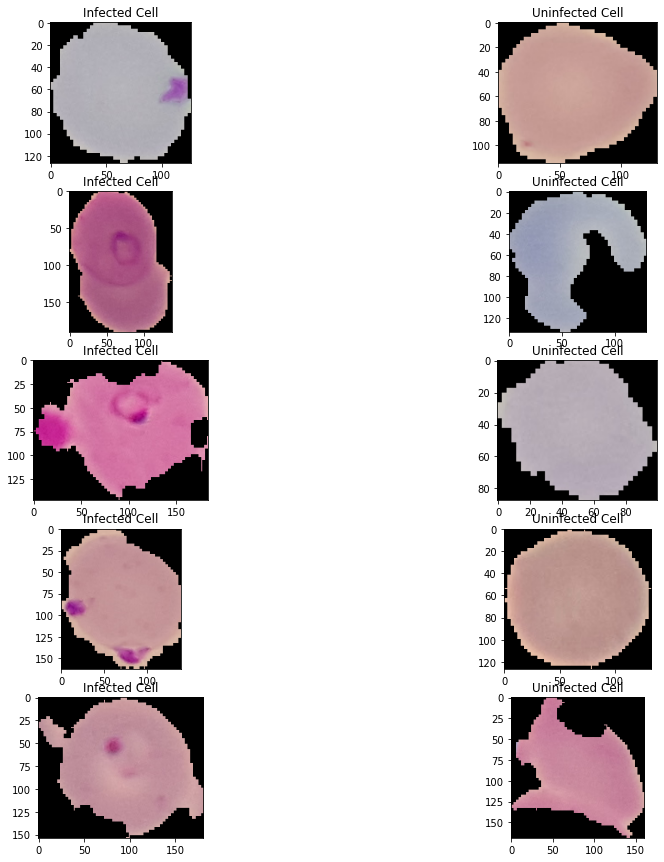

In [57]:
num_examples = 5
curr_num = 0
seed = 42

plt.figure(1, figsize = (15 , 15))
for i in range(num_examples):        
    rand = np.random.randint(0 , 8265, 1)
    img_inf = plt.imread("./train/parasitized/"+str(rand[0])+".png")
    rand = np.random.randint(0 , 8265, 1)
    img_uninf = plt.imread("./train/uninfected/"+str(rand[0])+".png")
    
 
    curr_num += 1 
    plt.subplot(5 , 2 , curr_num)
    plt.imshow(img_inf)
    plt.title('Infected Cell')   

    
    curr_num += 1 
    plt.subplot(5 , 2 , curr_num)
    plt.imshow(img_uninf)
    plt.title('Uninfected Cell')
    
plt.show()
    

On the pictures we can see that images have different size and cells themselves do not have any particular shape. There is no any background on the pictures which probably is going to have a better predictions. Visually infected cells can be clearly identified by purple artifacts on them which have more or less consistent color. Based on these facts data augemntation if applied properly also might iprove the results.

# Set Up the Framework

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [2]:
def make_model(_learning_rate=0.01, _momentum=0):
    inputs = keras.layers.Input(shape=(150,150,3))

    conv = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)

    pool = keras.layers.MaxPooling2D(pool_size=(2,2))(conv)

    vectors = keras.layers.Flatten()(pool)

    dense = keras.layers.Dense(64, activation='relu')(vectors)

    outputs = keras.layers.Dense(1,activation='sigmoid')(dense)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.SGD(learning_rate=_learning_rate, momentum=_momentum)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    
    return model

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
seed = 42
batch_size = 32

train_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory(
    './train',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed = seed
)

validation_generator = ImageDataGenerator(rescale=1./255)

val_ds = validation_generator.flow_from_directory(
    './validation',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed = seed,
    shuffle=False
)

# test_generator = ImageDataGenerator(rescale=1./255)

# test_ds = validation_generator.flow_from_directory(
#     './test',
#     target_size=(150,150),
#     class_mode='binary',
#     batch_size=20,
#     shuffle=False
# )

Found 16531 images belonging to 2 classes.
Found 5514 images belonging to 2 classes.


In [6]:
train_ds.class_indices, val_ds.class_indices

({'parasitized': 0, 'uninfected': 1}, {'parasitized': 0, 'uninfected': 1})

In [10]:
model = make_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                11214912  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
_______________________________________________

# Model tuning

Training model 15 epochs with default aprameters

In [11]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds
)

Epoch 1/15
517/517 [==============================] - 104s 200ms/step - loss: 0.6948 - accuracy: 0.5462 - val_loss: 0.6735 - val_accuracy: 0.6474
Epoch 2/15
517/517 [==============================] - 84s 163ms/step - loss: 0.6662 - accuracy: 0.6153 - val_loss: 0.6545 - val_accuracy: 0.6494
Epoch 3/15
517/517 [==============================] - 82s 159ms/step - loss: 0.6508 - accuracy: 0.6377 - val_loss: 0.6215 - val_accuracy: 0.6993
Epoch 4/15
517/517 [==============================] - 82s 159ms/step - loss: 0.6270 - accuracy: 0.6592 - val_loss: 0.5917 - val_accuracy: 0.6921
Epoch 5/15
517/517 [==============================] - 84s 163ms/step - loss: 0.6082 - accuracy: 0.6717 - val_loss: 0.5765 - val_accuracy: 0.7129
Epoch 6/15
517/517 [==============================] - 82s 159ms/step - loss: 0.5874 - accuracy: 0.6944 - val_loss: 0.5585 - val_accuracy: 0.7292
Epoch 7/15
517/517 [==============================] - 83s 160ms/step - loss: 0.5640 - accuracy: 0.7111 - val_loss: 0.5431 - val_a

Let's plot the accuracy

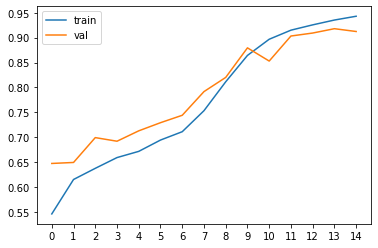

In [12]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(15))
plt.legend()

Model starts to overfit after 13-14 epochs with default params, but reaches good accuracy already

Let's try to adjust learning rate. Let's increase number of epochs to compensate for slower learning rate and to have better picture overall

In [15]:
scores = {}

for lr in [0.001,0.01,0.1]:
    print(lr)
    model = make_model(lr)
    history = model.fit(train_ds, epochs=18, validation_data=val_ds)
    scores[lr] = history.history
    print()
    print()

0.001
Epoch 1/18
517/517 [==============================] - 99s 190ms/step - loss: 0.6710 - accuracy: 0.5822 - val_loss: 0.6469 - val_accuracy: 0.6250
Epoch 2/18
517/517 [==============================] - 92s 177ms/step - loss: 0.6477 - accuracy: 0.6247 - val_loss: 0.6832 - val_accuracy: 0.5575
Epoch 3/18
517/517 [==============================] - 87s 167ms/step - loss: 0.6323 - accuracy: 0.6429 - val_loss: 0.6178 - val_accuracy: 0.6596
Epoch 4/18
517/517 [==============================] - 87s 169ms/step - loss: 0.6252 - accuracy: 0.6491 - val_loss: 0.6309 - val_accuracy: 0.6378
Epoch 5/18
517/517 [==============================] - 87s 168ms/step - loss: 0.6186 - accuracy: 0.6606 - val_loss: 0.6509 - val_accuracy: 0.6052
Epoch 6/18
517/517 [==============================] - 87s 168ms/step - loss: 0.6113 - accuracy: 0.6663 - val_loss: 0.6281 - val_accuracy: 0.6346
Epoch 7/18
517/517 [==============================] - 86s 166ms/step - loss: 0.6052 - accuracy: 0.6749 - val_loss: 0.5917 - 

Let's plot the results

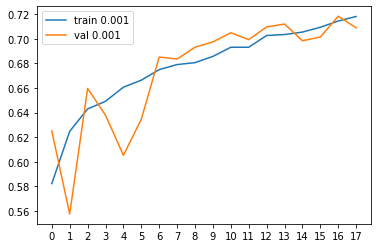

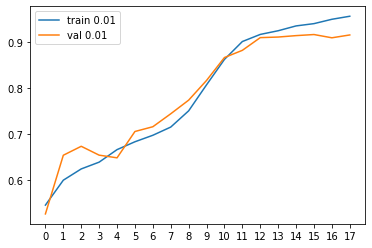

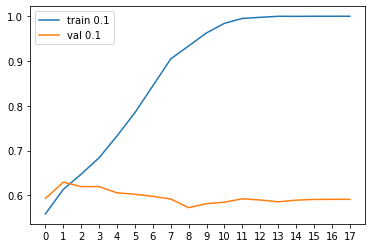

In [22]:
for lr, hist in scores.items():   
    #plt.plot(hist['accuracy'], label=lr)    
    plt.plot(hist['accuracy'], label='train %s' % lr)
    plt.plot(hist['val_accuracy'], label='val %s' % lr)
    plt.xticks(np.arange(18))
    plt.legend()
    plt.show()

From the plots we can see the following:
* Learning rate 0.001 is too slow
* Default learning rate 0.01 seems to be optimal under current circumstances, it's also shows consistent results with the first run
* Rate of 0.1 overfits very quickly and never reaches good results on validation dataset

Therefore learning rate of 0.01 with 13 epochs offers the best results so far with accuracy around 90%

Now let's try to pick different momentum

In [14]:
scores = {}

lr = 0.01
mm = 0.2
#for mm in [0.2,0.6,0.8]:
print(mm)
model = make_model(lr, mm)
history = model.fit(train_ds, epochs=15, validation_data=val_ds)
scores[mm] = history.history

0.2
Epoch 1/15
517/517 [==============================] - 88s 170ms/step - loss: 0.6933 - accuracy: 0.5582 - val_loss: 0.6756 - val_accuracy: 0.5250
Epoch 2/15
517/517 [==============================] - 86s 166ms/step - loss: 0.6596 - accuracy: 0.6153 - val_loss: 0.6471 - val_accuracy: 0.6230
Epoch 3/15
517/517 [==============================] - 87s 167ms/step - loss: 0.6287 - accuracy: 0.6502 - val_loss: 0.6085 - val_accuracy: 0.6772
Epoch 4/15
517/517 [==============================] - 88s 169ms/step - loss: 0.5979 - accuracy: 0.6831 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 5/15
517/517 [==============================] - 86s 167ms/step - loss: 0.5633 - accuracy: 0.7092 - val_loss: 0.5385 - val_accuracy: 0.7499
Epoch 6/15
517/517 [==============================] - 89s 171ms/step - loss: 0.4967 - accuracy: 0.7718 - val_loss: 0.5696 - val_accuracy: 0.7182
Epoch 7/15
517/517 [==============================] - 82s 159ms/step - loss: 0.4016 - accuracy: 0.8472 - val_loss: 0.3935 - va

In [16]:

mm = 0.6
#for mm in [0.2,0.6,0.8]:
print(mm)
model = make_model(lr, mm)
history = model.fit(train_ds, epochs=15, validation_data=val_ds)
scores[mm] = history.history

0.6
Epoch 1/15
517/517 [==============================] - 85s 164ms/step - loss: 0.6672 - accuracy: 0.5925 - val_loss: 0.6231 - val_accuracy: 0.6745
Epoch 2/15
517/517 [==============================] - 85s 165ms/step - loss: 0.6155 - accuracy: 0.6584 - val_loss: 0.5730 - val_accuracy: 0.7151
Epoch 3/15
517/517 [==============================] - 87s 168ms/step - loss: 0.5635 - accuracy: 0.7139 - val_loss: 0.5037 - val_accuracy: 0.7706
Epoch 4/15
517/517 [==============================] - 84s 163ms/step - loss: 0.4065 - accuracy: 0.8351 - val_loss: 0.3461 - val_accuracy: 0.8769
Epoch 5/15
517/517 [==============================] - 81s 156ms/step - loss: 0.2908 - accuracy: 0.8926 - val_loss: 0.2831 - val_accuracy: 0.9019
Epoch 6/15
517/517 [==============================] - 84s 162ms/step - loss: 0.2382 - accuracy: 0.9122 - val_loss: 0.2318 - val_accuracy: 0.9227
Epoch 7/15
517/517 [==============================] - 82s 159ms/step - loss: 0.1963 - accuracy: 0.9275 - val_loss: 0.2683 - va

In [18]:
mm = 0.8
#for mm in [0.2,0.6,0.8]:
print(mm)
model = make_model(lr, mm)
history = model.fit(train_ds, epochs=15, validation_data=val_ds)
scores[mm] = history.history

0.8
Epoch 1/15
517/517 [==============================] - 83s 160ms/step - loss: 0.6635 - accuracy: 0.5925 - val_loss: 0.6768 - val_accuracy: 0.5531
Epoch 2/15
517/517 [==============================] - 78s 152ms/step - loss: 0.4584 - accuracy: 0.7947 - val_loss: 0.2755 - val_accuracy: 0.9053
Epoch 3/15
517/517 [==============================] - 80s 155ms/step - loss: 0.2538 - accuracy: 0.9089 - val_loss: 0.2677 - val_accuracy: 0.9084
Epoch 4/15
517/517 [==============================] - 83s 161ms/step - loss: 0.1970 - accuracy: 0.9261 - val_loss: 0.2080 - val_accuracy: 0.9273
Epoch 5/15
517/517 [==============================] - 84s 161ms/step - loss: 0.1733 - accuracy: 0.9347 - val_loss: 0.2060 - val_accuracy: 0.9309
Epoch 6/15
517/517 [==============================] - 83s 161ms/step - loss: 0.1512 - accuracy: 0.9422 - val_loss: 0.2108 - val_accuracy: 0.9305
Epoch 7/15
517/517 [==============================] - 83s 160ms/step - loss: 0.1148 - accuracy: 0.9536 - val_loss: 0.2345 - va

Results with different momentum

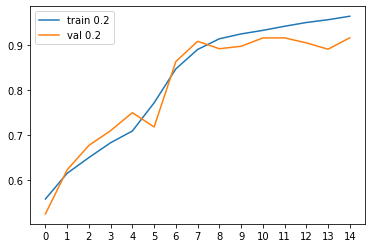

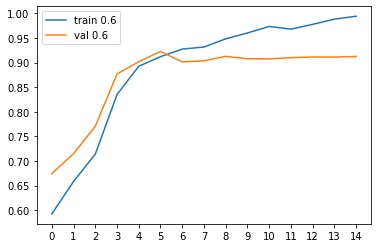

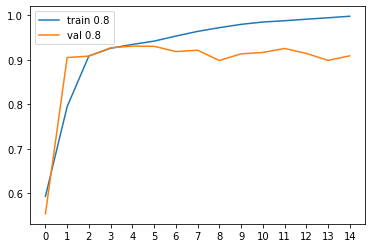

In [19]:
for mm, hist in scores.items():   
    plt.plot(hist['accuracy'], label='train %s' % mm)
    plt.plot(hist['val_accuracy'], label='val %s' % mm)
    plt.xticks(np.arange(15))
    plt.legend()
    plt.show()

With momentum = 0.8 we are getting quite decent result with accuracy approx 93% and loss 0.2 after four epochs. Let's stick with these parameters

Let's try to o add more layers now and play with the number of filters in convolutional layer and number of units in a dense layer. First of all let's try to add additional Conv2D and pooling layers. 16 and 32 combination does not give almost anything, but following ssettings imnproves the result to 0.94 after five epochs

In [33]:
def make_model():
    inputs = keras.layers.Input(shape=(150,150,3))

    conv1 = keras.layers.Conv2D(filters=32, kernel_size=(6,6), activation='relu')(inputs)
    
    pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(pool1)

    pool2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    vectors = keras.layers.Flatten()(pool2)

    dense = keras.layers.Dense(64, activation='relu')(vectors)

    outputs = keras.layers.Dense(1,activation='sigmoid')(dense)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    
    return model

In [34]:
model = make_model()
history = model.fit(train_ds, epochs=8, validation_data=val_ds)

Epoch 1/8
517/517 [==============================] - 154s 297ms/step - loss: 0.6594 - accuracy: 0.5972 - val_loss: 0.6393 - val_accuracy: 0.6529
Epoch 2/8
517/517 [==============================] - 151s 293ms/step - loss: 0.3566 - accuracy: 0.8555 - val_loss: 0.1964 - val_accuracy: 0.9331
Epoch 3/8
517/517 [==============================] - 151s 291ms/step - loss: 0.2257 - accuracy: 0.9154 - val_loss: 0.1886 - val_accuracy: 0.9367
Epoch 4/8
517/517 [==============================] - 151s 291ms/step - loss: 0.1854 - accuracy: 0.9327 - val_loss: 0.1954 - val_accuracy: 0.9373
Epoch 5/8
517/517 [==============================] - 152s 294ms/step - loss: 0.1644 - accuracy: 0.9416 - val_loss: 0.1804 - val_accuracy: 0.9412
Epoch 6/8
517/517 [==============================] - 152s 295ms/step - loss: 0.1479 - accuracy: 0.9465 - val_loss: 0.1876 - val_accuracy: 0.9414
Epoch 7/8
517/517 [==============================] - 155s 300ms/step - loss: 0.1324 - accuracy: 0.9506 - val_loss: 0.1799 - val_ac

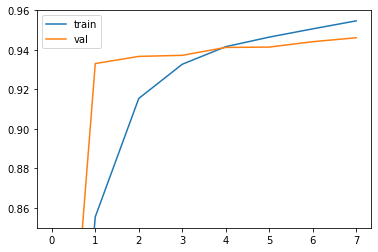

In [35]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(8))
plt.ylim(0.85, 0.96)
plt.legend()

In [37]:
def make_model(dense_units = 64):
    inputs = keras.layers.Input(shape=(150,150,3))

    conv1 = keras.layers.Conv2D(filters=32, kernel_size=(6,6), activation='relu')(inputs)
    
    pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(pool1)

    pool2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    vectors = keras.layers.Flatten()(pool2)

    dense = keras.layers.Dense(units=dense_units, activation='relu')(vectors)

    outputs = keras.layers.Dense(1,activation='sigmoid')(dense)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    
    return model

In [40]:
scores = {}

for u in [32, 128]:
    print(u)
    model = make_model(u)
    history = model.fit(train_ds, epochs=8, validation_data=val_ds)
    scores[u] = history.history

32
Epoch 1/8
517/517 [==============================] - 158s 305ms/step - loss: 0.6740 - accuracy: 0.5726 - val_loss: 0.6519 - val_accuracy: 0.6175
Epoch 2/8
517/517 [==============================] - 153s 295ms/step - loss: 0.5491 - accuracy: 0.7177 - val_loss: 0.3592 - val_accuracy: 0.8591
Epoch 3/8
517/517 [==============================] - 153s 296ms/step - loss: 0.2451 - accuracy: 0.9109 - val_loss: 0.2625 - val_accuracy: 0.9140
Epoch 4/8
517/517 [==============================] - 154s 297ms/step - loss: 0.1941 - accuracy: 0.9287 - val_loss: 0.1931 - val_accuracy: 0.9369
Epoch 5/8
517/517 [==============================] - 152s 295ms/step - loss: 0.1669 - accuracy: 0.9376 - val_loss: 0.1811 - val_accuracy: 0.9409
Epoch 6/8
517/517 [==============================] - 153s 295ms/step - loss: 0.1535 - accuracy: 0.9435 - val_loss: 0.1711 - val_accuracy: 0.9434
Epoch 7/8
517/517 [==============================] - 153s 295ms/step - loss: 0.1440 - accuracy: 0.9464 - val_loss: 0.2015 - val

let's plot results

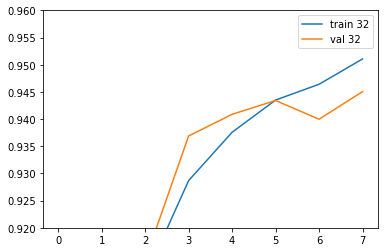

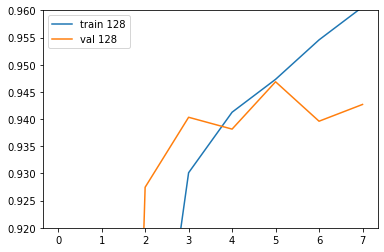

In [43]:
for u, hist in scores.items():   
    plt.plot(hist['accuracy'], label='train %s' % u)
    plt.plot(hist['val_accuracy'], label='val %s' % u)
    plt.xticks(np.arange(8))
    plt.ylim(0.92, 0.96)
    plt.legend()
    plt.show()

According to plots changing number of units alopne does not improve the model in any significant way

Now let's try to add data augementation

In [58]:
seed = 42
batch_size = 32

train_generator = ImageDataGenerator(
    rescale=1./255,    
    rotation_range=40,    
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest')

train_ds = train_generator.flow_from_directory(
    './train',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed = seed
)

validation_generator = ImageDataGenerator(rescale=1./255)

val_ds = validation_generator.flow_from_directory(
    './validation',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed = seed,
    shuffle=False
)

Found 16531 images belonging to 2 classes.
Found 5514 images belonging to 2 classes.


In [59]:
model = make_model()
history = model.fit(train_ds, epochs=8, validation_data=val_ds)

Epoch 1/8
517/517 [==============================] - 188s 363ms/step - loss: 0.6863 - accuracy: 0.5475 - val_loss: 0.6709 - val_accuracy: 0.6250
Epoch 2/8
517/517 [==============================] - 170s 329ms/step - loss: 0.5700 - accuracy: 0.7062 - val_loss: 0.2858 - val_accuracy: 0.9148
Epoch 3/8
517/517 [==============================] - 168s 324ms/step - loss: 0.3106 - accuracy: 0.8796 - val_loss: 0.2018 - val_accuracy: 0.9353
Epoch 4/8
517/517 [==============================] - 169s 327ms/step - loss: 0.2402 - accuracy: 0.9153 - val_loss: 0.2238 - val_accuracy: 0.9295
Epoch 5/8
517/517 [==============================] - 166s 322ms/step - loss: 0.2193 - accuracy: 0.9250 - val_loss: 0.1832 - val_accuracy: 0.9398
Epoch 6/8
517/517 [==============================] - 162s 314ms/step - loss: 0.2159 - accuracy: 0.9269 - val_loss: 0.2308 - val_accuracy: 0.8917
Epoch 7/8
517/517 [==============================] - 163s 315ms/step - loss: 0.2097 - accuracy: 0.9252 - val_loss: 0.1884 - val_ac

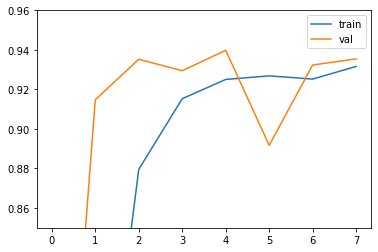

In [60]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(8))
plt.ylim(0.85, 0.96)
plt.legend()

The assumption made in EDA that data augemntation can bring some value proven to be wrong, at least with given parameters. 

# Training final model

So we will train our final model with the following code

In [61]:
seed = 42
batch_size = 32

train_generator = ImageDataGenerator(rescale=1./255)

train_ds = train_generator.flow_from_directory(
    './train',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed = seed
)

validation_generator = ImageDataGenerator(rescale=1./255)

val_ds = validation_generator.flow_from_directory(
    './validation',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed = seed,
    shuffle=False
)

Found 16531 images belonging to 2 classes.
Found 5514 images belonging to 2 classes.


In [62]:
def make_model():
    inputs = keras.layers.Input(shape=(150,150,3))

    conv1 = keras.layers.Conv2D(filters=32, kernel_size=(6,6), activation='relu')(inputs)
    
    pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(pool1)

    pool2 = keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    vectors = keras.layers.Flatten()(pool2)

    dense = keras.layers.Dense(units=64, activation='relu')(vectors)

    outputs = keras.layers.Dense(1,activation='sigmoid')(dense)

    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    
    return model

In [63]:
model = make_model()
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
517/517 [==============================] - 160s 308ms/step - loss: 0.6676 - accuracy: 0.5907 - val_loss: 0.6675 - val_accuracy: 0.5997
Epoch 2/5
517/517 [==============================] - 152s 293ms/step - loss: 0.4232 - accuracy: 0.8019 - val_loss: 0.2162 - val_accuracy: 0.9226
Epoch 3/5
517/517 [==============================] - 151s 292ms/step - loss: 0.2391 - accuracy: 0.8974 - val_loss: 0.1883 - val_accuracy: 0.9336
Epoch 4/5
517/517 [==============================] - 157s 303ms/step - loss: 0.1882 - accuracy: 0.9293 - val_loss: 0.2053 - val_accuracy: 0.9333
Epoch 5/5
517/517 [==============================] - 154s 297ms/step - loss: 0.1637 - accuracy: 0.9399 - val_loss: 0.1815 - val_accuracy: 0.9378


The model trined with tuned parameters offers accuracy close to 94% with loss around 0.18 on validation dataset. This is consistent with previous results

# Model Validation

In [64]:
test_generator = ImageDataGenerator(rescale=1./255)

test_ds = validation_generator.flow_from_directory(
    './test',
    target_size=(150,150),
    class_mode='binary',
    batch_size=batch_size,
    seed=seed,
    shuffle=False
)

Found 5512 images belonging to 2 classes.


In [65]:
result = model.evaluate(test_ds)

173/173 [==============================] - 68s 392ms/step - loss: 0.1875 - accuracy: 0.9376


Evaluation on a test dataset shows the results consistent with train and validation. Therefore this model is final with accuracy approx 94%.